## Pruebas de seguimiento solar y demanda neta

# Funciones y datos

In [1]:
# Importamos librerías
import os
import rasterio
import numpy                           as np
import pandas                          as pd
import geopandas                       as gpd
import xarray                          as xr
import xesmf                           as xe
from   matplotlib        import pyplot as plt
from   scipy             import stats
from   scipy             import optimize
from   matplotlib.ticker import StrMethodFormatter

In [2]:
# Funciones trigonométricas.
def sin(x) : return np.sin(np.radians(x))
def cos(x) : return np.cos(np.radians(x))
def tan(x) : return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

# Funciones para claves de regiones eléctricas

# Clave a número
def NUM_REGION(x):
    if   x == "BCA"  : y = 1
    elif x == "BCS"  : y = 2
    elif x == "CEN"  : y = 3
    elif x == "NES"  : y = 4
    elif x == "NOR"  : y = 5
    elif x == "NTE"  : y = 6
    elif x == "OCC"  : y = 7
    elif x == "ORI"  : y = 8
    elif x == "PEN"  : y = 9
    elif x == "PGE"  : y = 10
    elif x == "SCE"  : y = 11
    elif x == "SDGE" : y = 12
    elif x == "VEA"  : y = 13
    elif x == "COAST": y = 14
    elif x == "EAST" : y = 15
    elif x == "FWEST": y = 16
    elif x == "NORTH": y = 17
    elif x == "NCENT": y = 18
    elif x == "SOUTH": y = 19
    elif x == "SCENT": y = 20
    elif x == "WEST" : y = 21
    elif x == "LON"  : y = 22
    elif x == "LAT"  : y = 23
    elif x == "TOTAL": y = 24
    return y

# Número a clave
def NUM_REGION_r(x):
    if   x == 1 : y = "BCA"
    elif x == 2 : y = "BCS"
    elif x == 3 : y = "CEN"
    elif x == 4 : y = "NES"
    elif x == 5 : y = "NOR"
    elif x == 6 : y = "NTE"
    elif x == 7 : y = "OCC"
    elif x == 8 : y = "ORI"
    elif x == 9 : y = "PEN"
    elif x == 10: y = "PGE"
    elif x == 11: y = "SCE"
    elif x == 12: y = "SDGE"
    elif x == 13: y = "VEA"
    elif x == 14: y = "COAST"
    elif x == 15: y = "EAST"
    elif x == 16: y = "FWEST"
    elif x == 17: y = "NORTH"
    elif x == 18: y = "NCENT"
    elif x == 19: y = "SOUTH"
    elif x == 20: y = "SCENT"
    elif x == 21: y = "WEST"
    elif x == 22: y = "LON"
    elif x == 23: y = "LAT"
    elif x == 24: y = "TOTAL"
    return y

# Número a nombre
def NAME_REGION_r(x):
    if   x == 1 : y = "Baja California"
    elif x == 2 : y = "Baja California Sur"
    elif x == 3 : y = "Centro"
    elif x == 4 : y = "Noreste"
    elif x == 5 : y = "Noroeste"
    elif x == 6 : y = "Norte"
    elif x == 7 : y = "Occidente"
    elif x == 8 : y = "Oriente"
    elif x == 9 : y = "Peninsular"
    elif x == 10: y = "Pacific G&E"
    elif x == 11: y = "Southern Cal Edison"
    elif x == 12: y = "San Diego G&E"
    elif x == 13: y = "Valley Electric Assn"
    elif x == 14: y = "Coast"
    elif x == 15: y = "East"
    elif x == 16: y = "Far West"
    elif x == 17: y = "North"
    elif x == 18: y = "North Central"
    elif x == 19: y = "South"
    elif x == 20: y = "South Central"
    elif x == 21: y = "West"
    elif x == 22: y = "Longitudinal"
    elif x == 23: y = "Latitudinal"
    elif x == 24: y = "Total"
    return y

# Número a huso horario
def TIME_REGION_r(x):
    if   x == 1 : y = -8
    elif x == 2 : y = -7
    elif x == 3 : y = -6
    elif x == 4 : y = -6
    elif x == 5 : y = -7
    elif x == 6 : y = -6
    elif x == 7 : y = -6
    elif x == 8 : y = -6
    elif x == 9 : y = -6
    elif x == 10: y = -8
    elif x == 11: y = -8
    elif x == 12: y = -8
    elif x == 13: y = -8
    elif x == 14: y = -6
    elif x == 15: y = -6
    elif x == 16: y = -6
    elif x == 17: y = -6
    elif x == 18: y = -6
    elif x == 19: y = -6
    elif x == 20: y = -6
    elif x == 21: y = -6
    return y

# Número a diferencia de huso horario
def DELTA_REGION_r(x): return -( TIME_REGION_r(x) + 8 )

In [3]:
# Datos de radiación

# Rutas de archivos
path_f = "../data/"
name_f = "NSRDB_4km_2022_00.nc"

# Cargamos archivos de radiación
ds = xr.open_dataset(path_f + name_f).drop_vars("UVHI")
# Convertimos a fecha.
ds["hour"] = ( ds["time"].dt.hour + ds["time"].dt.minute / 60 ).copy()
ds["dayofyear"] = ds["time"].dt.dayofyear.copy()

# Regiones eléctricas
regiones_p = "../results/Mapas/Electric_regions"
regiones = gpd.read_file(regiones_p)

# Líneas de transmisión
transmision_p = "../results/Mapas/study_region_transmission_lines"
transmision = gpd.read_file(transmision_p).to_crs(6363)
transmision["potential_solar_park_zones"] = transmision.buffer(5000)
transmision = transmision.set_geometry("potential_solar_park_zones")
potential_solar_park_zones = transmision.dissolve(
    ).loc[0, "potential_solar_park_zones"]

# Vemos en qué región cae cada punto
points = ds.isel(time = 0)["Temperature"].to_dataframe(
    ).reset_index().drop( columns = ["time", "Temperature"] )
points["geometry"] = gpd.points_from_xy(points["lon"], points["lat"])
points = gpd.GeoDataFrame(points)
points["REGION"] = np.nan
for row in regiones.itertuples():
    points["MASK_REG"] = points.within(row.geometry)
    points["REGION"] = points["REGION"].where(
        ~points["MASK_REG"], row.ID_NUMBER )

# Vemos si el punto cae cerca de una línea de transmisión
points["potential_solar_park_zones"] = 0
points["MASK_ZONE"] = points.within(potential_solar_park_zones)
points["potential_solar_park_zones"] = points["potential_solar_park_zones"
    ].where( points["MASK_ZONE"], 1 )

# Agregamos la información al dataframe
REGION = points.set_index( ["lon", "lat"]
    )[ ["REGION", "potential_solar_park_zones"] ].to_xarray()
ds = xr.merge([ds, REGION])

# Producción fotovoltaica

In [4]:
# Cálculo de posición solar

ds["Time_zone"] = xr.apply_ufunc(TIME_REGION_r, ds["REGION"], vectorize = True)
TZ = ds["Time_zone"]
lat = ds["lat"]
lon = ds["lon"]

# Eccentric anomaly of the earth in its orbit around the sun.
ds["Day_Angle"] = 6.283185 * ( ds["dayofyear"] - 1 ) / 365
# Declinación.
ds["Declination"] = ( ( 0.006918 - 0.399912 * np.cos(ds["Day_Angle"])
    + 0.070257*np.sin(ds["Day_Angle"])
    - 0.006758*np.cos(2*ds["Day_Angle"])
    + 0.000907*np.sin(2*ds["Day_Angle"])
    - 0.002697*np.cos(3*ds["Day_Angle"])
    + 0.00148*np.sin(3*ds["Day_Angle"]) ) * 180/np.pi )
# Ecuación del tiempo.
ds["Time_Equation"] = ( ( 0.000075 + 0.001868*np.cos(ds["Day_Angle"])
    - 0.032077*np.sin(ds["Day_Angle"])
    - 0.014615*np.cos(2*ds["Day_Angle"])
    -0.040849*np.sin(2*ds["Day_Angle"])) * 229.18 )
# Longitud del punto subsolar.
ds["lon_subs"] = -15 * ( ds["hour"] - TZ
    + ds["Time_Equation"]/60 )
# Ángulo horario.
ds["Hour_Angle"] = ( 15 * ( ds["hour"] - 12
    - ds["Time_Equation"]/60 + ((lon-TZ*15)*4)/60 ) )
ds = ds.drop_vars( ["Time_Equation"] )
# Posiciones del analema solar.
ds["Sz"] = ( sin(lat)*sin(ds["Declination"])
    - cos(lat)*cos(ds["Declination"])
    *cos(ds["lon_subs"]-lon) )
ds = ds.drop_vars( ["lon_subs"] )
# Ángulo del cénit solar.
ds["Zenith_Angle"] = acos(ds["Sz"])
ds = ds.drop_vars( "Sz" )
# Ángulo acimutal solar.
ds["Azimuth_Angle"] = acos( ( sin(ds["Declination"])
    - cos(ds["Zenith_Angle"])*sin(lat) )
    / ( sin(ds["Zenith_Angle"])*cos(lat) ) )
ds["Azimuth_Angle"] = ds["Azimuth_Angle"].where(
    ds["Hour_Angle"] < 0, 360 - ds["Azimuth_Angle"] )
ds = ds.drop_vars( ["Declination", "Hour_Angle"] )
# Masa de aire.
ds["Air_Mass"] = ( 1/(cos(ds["Zenith_Angle"])
    + 0.15/(93.885 - ds["Zenith_Angle"])**1.253 )
    * ds["Pressure"]/1013.25 )
ds["Air_Mass"] = ds["Air_Mass"].where( ds["Zenith_Angle"] < 85.5, 0 )
ds = ds.drop_vars( ["Day_Angle", "Pressure"] )

In [5]:
# Casos de orientación de sistemas fotovoltaico

# Casos a estudiar
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_vertical_west_main",
    "bifacial_vertical_east_main", "bifacial_vertical_west_back",
    "bifacial_vertical_east_back", "bifacial_south_back" ]
# Variables fotovoltaicas por caso
# Inclinación
track_tilt       =   [ f"{x}_Tilt"               for x in cases ]
# Azimuth
track_azimuth    =   [ f"{x}_Azimuth"            for x in cases ]
# Ángulo entre el panel y el sol, Angle of Incidence
track_AOI        =   [ f"{x}_Angle_of_Incidence" for x in cases ]
# Radiación incidente en el panel [W/m^2], Plane of Array Irradiace
track_POA        =   [ f"{x}_POA"                for x in cases ]
# Producción fotovoltaica por kilowatt de capacidad [W/kWp]
track_P_mp       = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_west_P_mp",
        "bifacial_vertical_east_P_mp",
        "bifacial_south_P_mp" ] )
# Producción para cada caso
prod_n           = track_P_mp[0:5] + track_P_mp[10:]
# Factor bifacial
P_bf = [ 1, 1, 1, 1, 1, 1, 1, 0.7, 0.7, 0.7 ]

# Ángulos de orientación de los sistemas
# Orientación del seguidor de un eje
# Asumimos inclinación de 0 grados
azimuth_tracker = 180
# south_no_track
ds[track_azimuth[0]] = 180
ds[track_tilt[0]   ] = lat
# west_no_track
ds[track_azimuth[1]] = 270
ds[track_tilt[1]   ] = lat
# east_no_track
ds[track_azimuth[2]] = 90
ds[track_tilt[2]   ] = lat
# 1_track
ds[track_tilt[3]   ] = np.abs( atan( tan(ds["Zenith_Angle"])
    * sin(ds["Azimuth_Angle"] - azimuth_tracker) ) )
ds[track_azimuth[3]] = 90
ds[track_azimuth[3]] = ds["1_track_Azimuth"
    ].where(ds["Azimuth_Angle"]<180, 270)
# 2_track
ds[track_tilt[4]   ] = ds["Zenith_Angle"]
ds[track_azimuth[4]] = ds["Azimuth_Angle"]
# bifacial_vertical_west_main
ds[track_tilt[5]   ] = 90
ds[track_azimuth[5]] = 270
# bifacial_vertical_east_main
ds[track_tilt[6]   ] = 90
ds[track_azimuth[6]] = 90
# bifacial_vertical_west_back
ds[track_tilt[7]   ] = 90
ds[track_azimuth[7]] = 90
# bifacial_vertical_east_back
ds[track_tilt[8]   ] = 90
ds[track_azimuth[8]] = 270
# bifacial_south_back
ds[track_tilt[9]   ] = 90 + lat
ds[track_azimuth[9]] = 0

In [6]:
# Producción fotovoltaica

# Modelo de Pérez de Cielo Difuso para calcular 
# la radiación en un plano inclinado
# Diffuse Horizontal Radiation.
ds["DHI"] = ds["GHI"] - ds["DNI"] * cos(ds["Zenith_Angle"])
ds["DHI"] = ds["DHI"].clip(min = 0.001)
K = 5.535e-6
# Perez clearness bins.
ds["bins"] = 0
ds["bins"] = ds["bins"].where( ds["DHI"] == 0.001,
    ( (ds["DHI"]+ds["DNI"])/ds["DHI"] + K*ds["Zenith_Angle"]**3 )
    / ( 1 + K*ds["Zenith_Angle"]**3 ) )
ds["DHI"] = ds["DHI"].where(ds["DHI"]>0.001, 0)
ds["epsilon"] = xr.where( (ds["bins"]>6.200), 8, ds["bins"] )
ds["epsilon"] = xr.where( (ds["bins"]>4.500)
    & (ds["bins"]<6.200), 7, ds["epsilon"] )
ds["epsilon"] = xr.where( (ds["bins"]>2.600)
    & (ds["bins"]<4.500), 6, ds["epsilon"] )
ds["epsilon"] = xr.where((ds["bins"]>1.950)
    & (ds["bins"]<2.600), 5, ds["epsilon"] )
ds["epsilon"] = xr.where( (ds["bins"]>1.500)
    & (ds["bins"]<1.950), 4, ds["epsilon"] )
ds["epsilon"] = xr.where( (ds["bins"]>1.230)
    & (ds["bins"]<1.500), 3, ds["epsilon"] )
ds["epsilon"] = xr.where( (ds["bins"]>1.065)
    & (ds["bins"]<1.500), 2, ds["epsilon"] )
ds["epsilon"] = xr.where( (ds["bins"]<1.065), 1, ds["epsilon"] )
Perez = pd.read_csv("../code/Perez.csv", index_col = "bin" )
ds = ds.drop_vars( "bins" )
# Extraterrestrial radiation.
Ea = 1367
# Coeficientes
ds["Delta"] = ds["DHI"] * ds["Air_Mass"] / Ea
ds = ds.drop_vars( "Air_Mass" )
for j in Perez.columns:
    ds[j] = 0.0
    for i in Perez.index:
        ds[j] = ds[j].where(ds["epsilon"] != i, Perez.loc[i, j] )
ds = ds.drop_vars( "epsilon" )
ds["F1"] = ( ds["f11"] + ds["f12"]*ds["Delta"]
    + np.radians(ds["Zenith_Angle"])*ds["f13"] )
ds = ds.drop_vars( ["f11", "f12", "f13"] )
ds["F1"] = ds["F1"].clip(max = 0)
ds["F2"] = ( ds["f21"] + ds["f22"]*ds["Delta"]
    + np.radians(ds["Zenith_Angle"])*ds["f23"] )
ds = ds.drop_vars( ["f21", "f22", "f23", "Delta"] )
ds["b"] = cos(ds["Zenith_Angle"])
ds["b"] = ds["b"].clip(max = cos(85))
# Iteramos para cada caso
for i in range(len(cases)):
    # Ángulo entre el panel y el sol, Angle of Incidence
    ds[track_AOI[i]] = (
        cos(ds["Zenith_Angle"])*cos(ds[track_tilt[i]])
        + sin(ds["Zenith_Angle"])*sin(ds[track_tilt[i]])
        *cos(ds["Azimuth_Angle"]-ds[track_azimuth[i]]) )
    ds[track_AOI[i]] = ds[track_AOI[i]].clip(min = -1, max = 1)
    ds[track_AOI[i]] = acos(ds[track_AOI[i]])
    ds["a"] = cos(ds[track_AOI[i]])
    ds["a"] = ds["a"].clip(max = 0)
    # Radiación difusa.
    ds["I_d"] = ( ds["DHI"] * ( (1-ds["F1"])*((1+cos(ds[track_tilt[i]]))/2)
        + ds["F1"]*ds["a"]/ds["b"] + ds["F2"]*sin(ds[track_tilt[i]]) ) )
    ds["I_d_90"] = ( ds["DHI"] * ((1+cos(ds[track_tilt[i]]))/2) )
    ds["I_d"] = ds["I_d"].where( ds["Zenith_Angle"] < 87.5, ds["I_d_90"] )
    ds = ds.drop_vars( "I_d_90" )
    ds["I_d"] = ds["I_d"].where( ds["Zenith_Angle"] < 90, 0 )
    # Radiación directa.
    ds["I_b"] = ds["DNI"] * cos(ds[track_AOI[i]])
    ds["I_b"] = ds["I_b"].where( ds[track_AOI[i]] < 90, 0 )
    ds = ds.drop_vars( track_AOI[i] )
    # Radiación total en el panel.
    ds[track_POA[i]] = ds["I_b"] + ds["I_d"]
    ds = ds.drop_vars( ["I_b", "I_d"] )

ds = ds.drop_vars( ["F1", "F2", "a", "b", 
    "Zenith_Angle", "Azimuth_Angle", "DHI"] )

# NOCT Cell Temperature Model
T_NOCT    = 44 # °C
# Datos de Panel Canadian Solar 550 W
# Modelo: HiKu6 Mono PERC CS6W-550
I_mp      = 13.2 # A
V_mp      = 41.7 # V
A_m       = 1.134*2.278 # m^2
eff_ref   = I_mp * V_mp / (1000 * A_m)
tau_alpha = 0.9
# Ajuste de viento.
#v = 0.61 # Dos pisos.
v = 0.51 # Un piso.
# Ajuste de montaje.
T_adj = 2   + T_NOCT # Building integrated,
# greater than 3.5 in, or ground/rack mounted
#T_adj = 2  + T_NOCT # 2.5 to 3.5 in
#T_adj = 6  + T_NOCT # 1.5 to 2.5 in
#T_adj = 11 + T_NOCT # 0.5 to 1.5 in
#T_adj = 18 + T_NOCT # less than 0.5 in
# Iteramos para cada caso
for i in range(len(cases)):
    # Temperatura de la celda
    ds[cases[i] + "_Cell_Temperature"] = ( ds["Temperature"]
        + ds[track_POA[i]] / 800 * (T_adj-20)
        * (1-eff_ref/tau_alpha) * ( 9.5 / (5.7+3.8*v*ds["Wind Speed"]) ) )
ds = ds.drop_vars(["Wind Speed", "Temperature"])

# Simple efficiency module model
# Eficiencia por temperatura
eff_T = -0.34
# Pérdidas del sistema
eff_n = [ "Soiling", "Shading", "Snow", "Mismatch",
    "Wiring", "Connections", "Light_Induced_Degradation",
    "Nameplate_Rating", "Age", "Availability" ]
eff = np.array( [0.98, 0.97, 1, 0.98, 0.98,
    0.995, 0.985, 0.99, 1, 0.97] ).prod()
# Eficiencia del inversor
eff_inv = 0.96
# Eficiencia del sistema
eff_sys = eff_ref * eff_inv * eff
# DC to AC Size Ratio
DC_AC = 1.1
# Inverter size
inv_P = I_mp * V_mp / DC_AC

# Iteramos para cada caso
for i in range(len(cases)):
    # Potencia generada en AC
    ds[track_P_mp[i]] = ( P_bf[i] * ds[track_POA[i]]*eff_sys*A_m *
        ( 1 + eff_T/100 * (ds[cases[i] + "_Cell_Temperature"]-25) ) )
    ds[track_P_mp[i]] = ds[ track_P_mp[i] ].where(
        ds[track_P_mp[i]] < inv_P, inv_P )
    # El resultado es la generación por cada kWp.
    ds[track_P_mp[i]] = ds[track_P_mp[i]] / ( I_mp * V_mp )
    ds[track_P_mp[i]] = ds[track_P_mp[i]].where(
        ds[track_POA[i]] > 0, 0 ).where(ds["GHI"] > 0, 0)
    ds = ds.drop_vars( cases[i] + "_Cell_Temperature" )
    ds = ds.drop_vars( track_POA[i] )

# Calculamos la producción bifacial total
ds[track_P_mp[10]] = ds[track_P_mp[5]] + ds[track_P_mp[7]]
ds[track_P_mp[11]] = ds[track_P_mp[6]] + ds[track_P_mp[8]]
ds[track_P_mp[12]] = ds[track_P_mp[0]] + ds[track_P_mp[9]]
ds = ds.drop_vars(track_P_mp[5:10])

In [7]:
# Ponderamos la producción fotovoltaica

# Cargamos el área construida e interpolamos
built_n = "GHS_BUILT_S_E2020_GLOBE_R2023A_4326_30ss_V1_0"
built = xr.open_dataset(f"../data/Mapas/{built_n}/{built_n}.tif"
    ).isel({"band": 0}).drop_vars(["band", "spatial_ref"]).rename(
    {"x": "lon", "y": "lat", "band_data": "built_surface"}
    ).sel( {
    "lon": slice(ds["lon"].values.min()-0.02, ds["lon"].values.max()+0.02),
    "lat": slice(ds["lat"].values.max()+0.02, ds["lat"].values.min()-0.03) } )
built = built.coarsen({"lon": 2, "lat": 2}).sum()
regridder = xe.Regridder(built, ds, method = "bilinear")
ds["built_surface"] = regridder(built["built_surface"], keep_attrs=True)

# Para generación distribuida ponderamos con el área construida
prod_n_dist = [f"{x}_distributed" for x in prod_n]
ds[prod_n_dist] = ds[prod_n] * ds["built_surface"]
ds["built_surface_sum"] = ds["built_surface"].copy()
for c in ds["REGION"].values:
    ds["built_surface"] = xr.where( ds["REGION"] == c,
        ds["built_surface"].where(ds["REGION"] == c).sum(),
        ds["built_surface_sum"] )
ds[prod_n_dist] /= ds["built_surface_sum"]
# Podemos forzar a que la producción distribuida siempre sea hacia el sur
for v in prod_n_dist[1:]: ds[v] = ds[prod_n_dist[0]]

# Para parques solares ponderamos con las líneas de transmisión
prod_n_centr = [f"{x}_central" for x in prod_n]
ds[prod_n_centr] = ds[prod_n].where(ds["potential_solar_park_zones"])

# Unimos toda la producción
prod_n_total = [f"{x}_total" for x in prod_n]
for i, v in enumerate(prod_n_total):
    ds[v] = ( ds[prod_n_dist[i]] + ds[prod_n_centr[i]] ) / 2
prod_n_i = prod_n + prod_n_dist + prod_n_centr + prod_n_total

# Demanda

In [8]:
# Cargamos la demanda

# CENACE
# Ruta de la demanda para México
path_f = "../data/Demanda/Mexico/Original/"
# Cargamos cada archivo
df_i = []
for f in os.listdir(path_f):
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        # Asignamos columnas
        df_0.columns = ["Sistema", "Area", "Hora", "Generacion (MWh)",
            "Importacion Total (MWh)", "Exportacion Total (MWh)",
            "Intercambio neto entre Gerencias (MWh)",
            "Estimacion de Demanda por Balance (MWh)"]
        df_0 = df_0[ ["Sistema", "Area", "Hora",
            "Estimacion de Demanda por Balance (MWh)"] ]
        df_0["Area"] = df_0["Area"].where(
            df_0["Area"]!="BCA", df_0["Sistema"] )
        df_0 = df_0.drop(columns = "Sistema")
        # Damos formato a la fecha
        df_0["Fecha"] = f[40:50]
        df_i.append(df_0)
df_cenace = pd.concat(df_i)
df_i = []
for c in df_cenace["Area"].unique():
    df_i.append(df_cenace[df_cenace["Area"] == c].copy())
for i in range(len(df_i)):
    df_i[i]["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_cenace = pd.concat(df_i).rename( columns =
    {demanda: "Demand", "Area": "REGION"} )
df_cenace["REGION"] = df_cenace["REGION"].apply(NUM_REGION)
df_cenace = df_cenace.set_index(["time", "REGION"]).drop(
    columns = ["Fecha", "Hora"]).sort_index()

# ERCOT
path_ercot = "../data/Demanda/ERCOT/Native_Load_2022.xlsx"
df_ercot = pd.read_excel(path_ercot)
df_ercot["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_ercot = df_ercot.set_index("time").drop(columns = ["Hour Ending", "ERCOT"])
df_ercot = df_ercot.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_ercot["REGION"] = df_ercot["REGION"].apply(NUM_REGION)
df_ercot = df_ercot.set_index("REGION", append = True)

#CAISO
path_caiso = "../data/Demanda/CAISO/historicalemshourlyload-2022.xlsx"
df_caiso = pd.read_excel(path_caiso)
df_caiso["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_caiso = df_caiso.set_index("time").drop(columns = ["Date", "HR", "CAISO"])
df_caiso = df_caiso.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_caiso["REGION"] = df_caiso["REGION"].apply(NUM_REGION)
df_caiso = df_caiso.set_index("REGION", append = True)

# Unimos las regiones
ds_d = pd.concat( [df_ercot, df_caiso, df_cenace]
    ).sort_index().to_xarray().interp_like(ds)
ds_d["hour"] = ( ds_d["time"].dt.hour + ds_d["time"].dt.minute / 60 ).copy()
ds_d["dayofyear"] = ds_d["time"].dt.dayofyear.copy()

# Promediamos la generación por región
ds_c = ds.groupby("REGION").mean()

# Datos agregados para demanda
# Agrupamiento longitudinal
ds_d_i = ds_d.copy()
ds_d_i = ds_d_i.where(ds_d_i["REGION"].isin([1, 2, 4, 5, 6, 14, 19]))
for c in np.unique(ds_d_i["REGION"]):
    ds_d_i = xr.where( ds_d_i["REGION"] == c,
        ds_d_i.shift({"time": DELTA_REGION_r(c)}), ds_d_i )
ds_d_i["REGION"] = ds_d_i["REGION"].where(ds_d_i["REGION"] == 22, 22)
ds_d_i["hour"] = ( ds_d_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_d_i["dayofyear"] = ds_d_i["time"].dt.dayofyear.copy()
ds_d_2 = ds_d_i.groupby("REGION").sum().copy()
# Agrupamiento latitudinal
ds_d_i = ds_d.copy()
ds_d_i = ds_d_i.where(ds_d_i["REGION"].isin([1, 2, 10, 11, 12, 13]))
for c in np.unique(ds_d_i["REGION"]):
    ds_d_i = xr.where( ds_d_i["REGION"] == c,
        ds_d_i.shift({"time": DELTA_REGION_r(c)}), ds_d_i )
ds_d_i["REGION"] = ds_d_i["REGION"].where(ds_d_i["REGION"] == 23, 23)
ds_d_i["hour"] = ( ds_d_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_d_i["dayofyear"] = ds_d_i["time"].dt.dayofyear.copy()
ds_d_3 = ds_d_i.groupby("REGION").sum().copy()
# Agrupamiento total
ds_d_i = ds_d.copy()
for c in np.unique(ds_d_i["REGION"]):
    ds_d_i = xr.where( ds_d_i["REGION"] == c,
        ds_d_i.shift({"time": DELTA_REGION_r(c)}), ds_d_i )
ds_d_i["REGION"] = ds_d_i["REGION"].where(ds_d_i["REGION"] == 24, 24)
ds_d_i["hour"] = ( ds_d_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_d_i["dayofyear"] = ds_d_i["time"].dt.dayofyear.copy()
ds_d_4 = ds_d_i.groupby("REGION").sum().copy()
# Agregamos la información al dataset
ds_d = xr.concat([ds_d, ds_d_2, ds_d_3, ds_d_4], "REGION")

# Datos agregados para generación
# Agrupamiento longitudinal
ds_i = ds.copy()
ds_i = ds_i.where(ds_i["REGION"].isin([1, 2, 4, 5, 6, 14, 19
                                       , 3 # Agregado temporalmente en lo que se descargan todos los datos
                                       ]))
for c in np.unique(ds_i["REGION"]):
    ds_i = xr.where( ds_i["REGION"] == c,
        ds_i.shift({"time": DELTA_REGION_r(c)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 22, 22)
ds_i["hour"] = ( ds_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_i["dayofyear"] = ds_i["time"].dt.dayofyear.copy()
ds_c_2 = ds_i.groupby("REGION").mean().copy()
# Agrupamiento latitudinal
ds_i = ds.copy()
ds_i = ds_i.where(ds_i["REGION"].isin([1, 2, 10, 11, 12, 13
                                       , 3 # Agregado temporalmente en lo que se descargan todos los datos
                                       ]))
for c in np.unique(ds_i["REGION"]):
    ds_i = xr.where( ds_i["REGION"] == c,
        ds_i.shift({"time": DELTA_REGION_r(c)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 23, 23)
ds_i["hour"] = ( ds_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_i["dayofyear"] = ds_i["time"].dt.dayofyear.copy()
ds_c_3 = ds_i.groupby("REGION").mean().copy()
# Agrupamiento total
ds_i = ds.copy()
for c in np.unique(ds_i["REGION"]):
    ds_i = xr.where( ds_i["REGION"] == c,
        ds_i.shift({"time": DELTA_REGION_r(c)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 24, 24)
ds_i["hour"] = ( ds_i["time"].dt.hour
    + ds_d_i["time"].dt.minute / 60 ).copy()
ds_i["dayofyear"] = ds_i["time"].dt.dayofyear.copy()
ds_c_4 = ds_i.groupby("REGION").mean().copy()
ds_c = xr.concat([ds_c, ds_c_2, ds_c_3, ds_c_4], "REGION")

# Unimos demanda y producción
ds_c["Demand"] = ds_d["Demand"]

NameError: name 'demanda' is not defined

In [81]:
# Minimun capacity to reach zero net demand during duck's belly
prod_n_cap = [f"{x}_capacity" for x in prod_n_i]
# Función que determina la demanda mínima en términos de la capacidad
def demand(x, v, c):
    return (ds_c["Demand"] - ds_c[v] * x).sel({"REGION": c}).pipe(np.min)
# Encontramos la capacidad que ocasiona una demanda nula
for i, v in enumerate(prod_n_i):
    n = []
    for c in ds_c["REGION"].values:
        if c in [22, 23]: x0 = 5e4
        elif c in [24]: x0 = 5e5
        else:
            x0 = 5e3
        n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
    ds_c[prod_n_cap[i]] = ("REGION", n)
ds_c["min_capacity"] = ( "REGION",
    ds_c[prod_n_cap].to_dataframe().min(axis = 1).values )

# Net demand with capacity that produces zero demand
# Demanda neta [MW]
names_dn = ["South-facing", "West-facing", "East-facing",
    "1 axis tracking", "2 axis tracking", "Bifacial, vertical, west-facing",
    "Bifacial, vertical, east-facing", "Bifacial, south facing", ]
names_dn_t = ( names_dn + [f"{x}_distributed" for x in names_dn]
    + [f"{x}_central" for x in names_dn]
    + [f"{x}_total" for x in names_dn] )
track_net_demand = [ f"{x}_net_demand"  for x in names_dn_t ]
ds_c[track_net_demand] = ( ds_c["Demand"]
    - ds_c[prod_n_i] * ds_c[prod_n_cap].rename(
    dict(zip(prod_n_cap, prod_n_i))) * 1000 )
# Net demand with same capacity for all cases
prod_dn_min = [f"{x}_min" for x in track_net_demand]
ds_c[prod_dn_min] = ( ds_c["Demand"]
    - ds_c[prod_n_i] * ds_c["min_capacity"] * 1000 )
# Energy produced
ener = [ f"{x}_energy" for x in prod_n_i ]
ds_c[ener] = ( ds_c[prod_n_i]
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, prod_n_i))) / 1e3 #/ 2
    ).sum("time")
# Demand ramp
track_net_demand_dt = [ f"{x}_dt" for x in track_net_demand ]
ds_c[track_net_demand_dt] = ( ds_c[track_net_demand]
    - ds_c[track_net_demand].shift(time = 1) ) #* 2
ds_c["Demand_dt"] = ( ds_c["Demand"]
    - ds_c["Demand"].shift(time = 1) ) #* 2
# Capacity factor
cap_f = [ f"{x}_capacity_factor" for x in prod_n_i ]
ds_c[cap_f] = ( 100 * 1000 * ds_c[ener] / ( 24 * 365
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, ener))) ) )

# Demanda máxima
track_net_demand_max = [f"{x}_max_demand" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_max] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).max("time")
# Demanda mínima
track_net_demand_min = [f"{x}_min_demand" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_min] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).min("time")
# Rampa máxima
track_net_demand_dt_max = [f"{x}_max_ramp" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_dt_max] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).max("time")
# Rampa mínima
track_net_demand_dt_min = [f"{x}_min_ramp" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_dt_min] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).min("time")

# Producción total
prod_n_sum = [f"{x}_sum" for x in prod_n]
prod_n_dist_sum = [f"{x}_sum" for x in prod_n_dist]
prod_n_centr_sum = [f"{x}_sum" for x in prod_n_centr]
prod_n_total_sum = [f"{x}_sum" for x in prod_n_total]
prod_n_sum_i = ( prod_n_sum + prod_n_dist_sum
    + prod_n_centr_sum + prod_n_total_sum )
ds_c[prod_n_sum_i] = (
    ds_c[prod_n + prod_n_dist + prod_n_centr + prod_n_total] #/ 2
    ).sum("time")

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2914804835.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2914804835.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )


In [82]:
# Determinamos la configuración ideal
indicators = [ "Photovoltaic production per kWp", "Maximum capacity",
    "Photovoltaic production", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
    track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
# Ponderación
weights = [1] * len(indicators)
order = [0, 0, 0, 0, 1, 1]

# Escogemos las variables relevantes a ponderar
indicators = indicators[1:3] + indicators[5:6]
results    = results[1:3] + results[5:6]
weights    = weights[1:3] + weights[5:6]
order      = order[1:3] + order[5:6]

# Iteramos para cada región
df_i = []
for i, c in enumerate( ds_c["REGION"].values ):
    df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    df_ind = pd.DataFrame( index = names_dn,
        columns = ["REGION", "KIND"] + indicators )
    df_ind.index.name = "CONFIGURATION"
    df_ind["REGION"] = c
    df_ind["KIND"] = "Value"
    df_ind_val = df_ind.copy()
    df_ind_val["KIND"] = "Rank"

    # Asignamos el rank percentile al conjunto de configuraciones
    for i, col in enumerate(indicators):
        df_ind[col] = df[results[i]].iloc[0].values
        df_ind_val[col] = np.abs( 100 * order[i]
            - stats.percentileofscore(df_ind[col], df_ind[col]) )
    df_ind_val["Score"] = ( df_ind_val[indicators].sum(axis = 1)
        / df_ind_val[indicators].shape[1] )

    # Unimos valores y ranks
    df_ind = df_ind.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_ind_val = df_ind_val.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_i.append(pd.concat([df_ind, df_ind_val]))

# Calculamos la configuración con mejor rank
score = pd.concat(df_i).sort_index()
max_score = score.loc[ slice(None), "Rank", slice(None)
    ].sort_values(["REGION", "CONFIGURATION", "Score"]
    ).iloc[0::8].reset_index(level = "CONFIGURATION")["CONFIGURATION"]
pd.options.display.float_format = "{:,.1f}".format
score.loc[ slice(None), "Rank", slice(None)
    ].sort_values(["REGION", "CONFIGURATION", "Score"] )

Maximum capacity  \
REGION CONFIGURATION                                       
3.0    1 axis tracking                              37.5   
       2 axis tracking                              25.0   
       Bifacial, south facing                       12.5   
       Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
       East-facing                                  50.0   
       South-facing                                 62.5   
       West-facing                                  75.0   
22.0   1 axis tracking                              50.0   
       2 axis tracking                              25.0   
       Bifacial, south facing                       12.5   
       Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
       East-facing                                  62.5   
       South-facing                                 37.5   
       West-facing                                  75.0   
23.0   1 axis tracking                              50.0   
       2 axis tracking                              25.0   
       Bifacial, south facing                       12.5   
       Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
       East-facing                                  62.5   
       South-facing                                 37.5   
       West-facing                                  75.0   
24.0   1 axis tracking                              50.0   
       2 axis tracking                              25.0   
       Bifacial, south facing                       12.5   
       Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
       East-facing                                  62.5   
       South-facing                                 37.5   
       West-facing                                  75.0   

                                        Photovoltaic production  \
REGION CONFIGURATION                                              
3.0    1 axis tracking                                     75.0   
       2 axis tracking                                     87.5   
       Bifacial, south facing                              62.5   
       Bifacial, vertical, east-facing                     50.0   
       Bifacial, vertical, west-facing                    100.0   
       East-facing                                         12.5   
       South-facing                                        37.5   
       West-facing                                         25.0   
22.0   1 axis tracking                                     75.0   
       2 axis tracking                                     87.5   
       Bifacial, south facing                              50.0   
       Bifacial, vertical, east-facing                     62.5   
       Bifacial, vertical, west-facing                    100.0   
       East-facing                                         12.5   
       South-facing                                        37.5   
       West-facing                                         25.0   
23.0   1 axis tracking                                     62.5   
       2 axis tracking                                     75.0   
       Bifacial, south facing                              50.0   
       Bifacial, vertical, east-facing                     87.5   
       Bifacial, vertical, west-facing                    100.0   
       East-facing                                         25.0   
       South-facing                                        37.5   
       West-facing                                         12.5   
24.0   1 axis tracking                                     87.5   
       2 axis tracking                                     75.0   
       Bifacial, south facing                              50.0   
       Bifacial, vertical, east-facing                  

# Resumen de regiones

In [83]:
# REunimos los datos relevantes para el resumen
ds_r = ds_c[ ener + cap_f + prod_n_cap + prod_n_sum + prod_n_dist_sum
    + prod_n_centr_sum + prod_n_total_sum + track_net_demand_max
    + track_net_demand_min + track_net_demand_dt_max]
df_r = ds_r.to_dataframe()
df_r = df_r.reset_index()
df_r["REGION"] = df_r["REGION"].apply(NUM_REGION_r)
df_r = df_r.set_index("REGION")

solar_cat = ["Unweighted", "Distributed", "Centralized", "Total"]

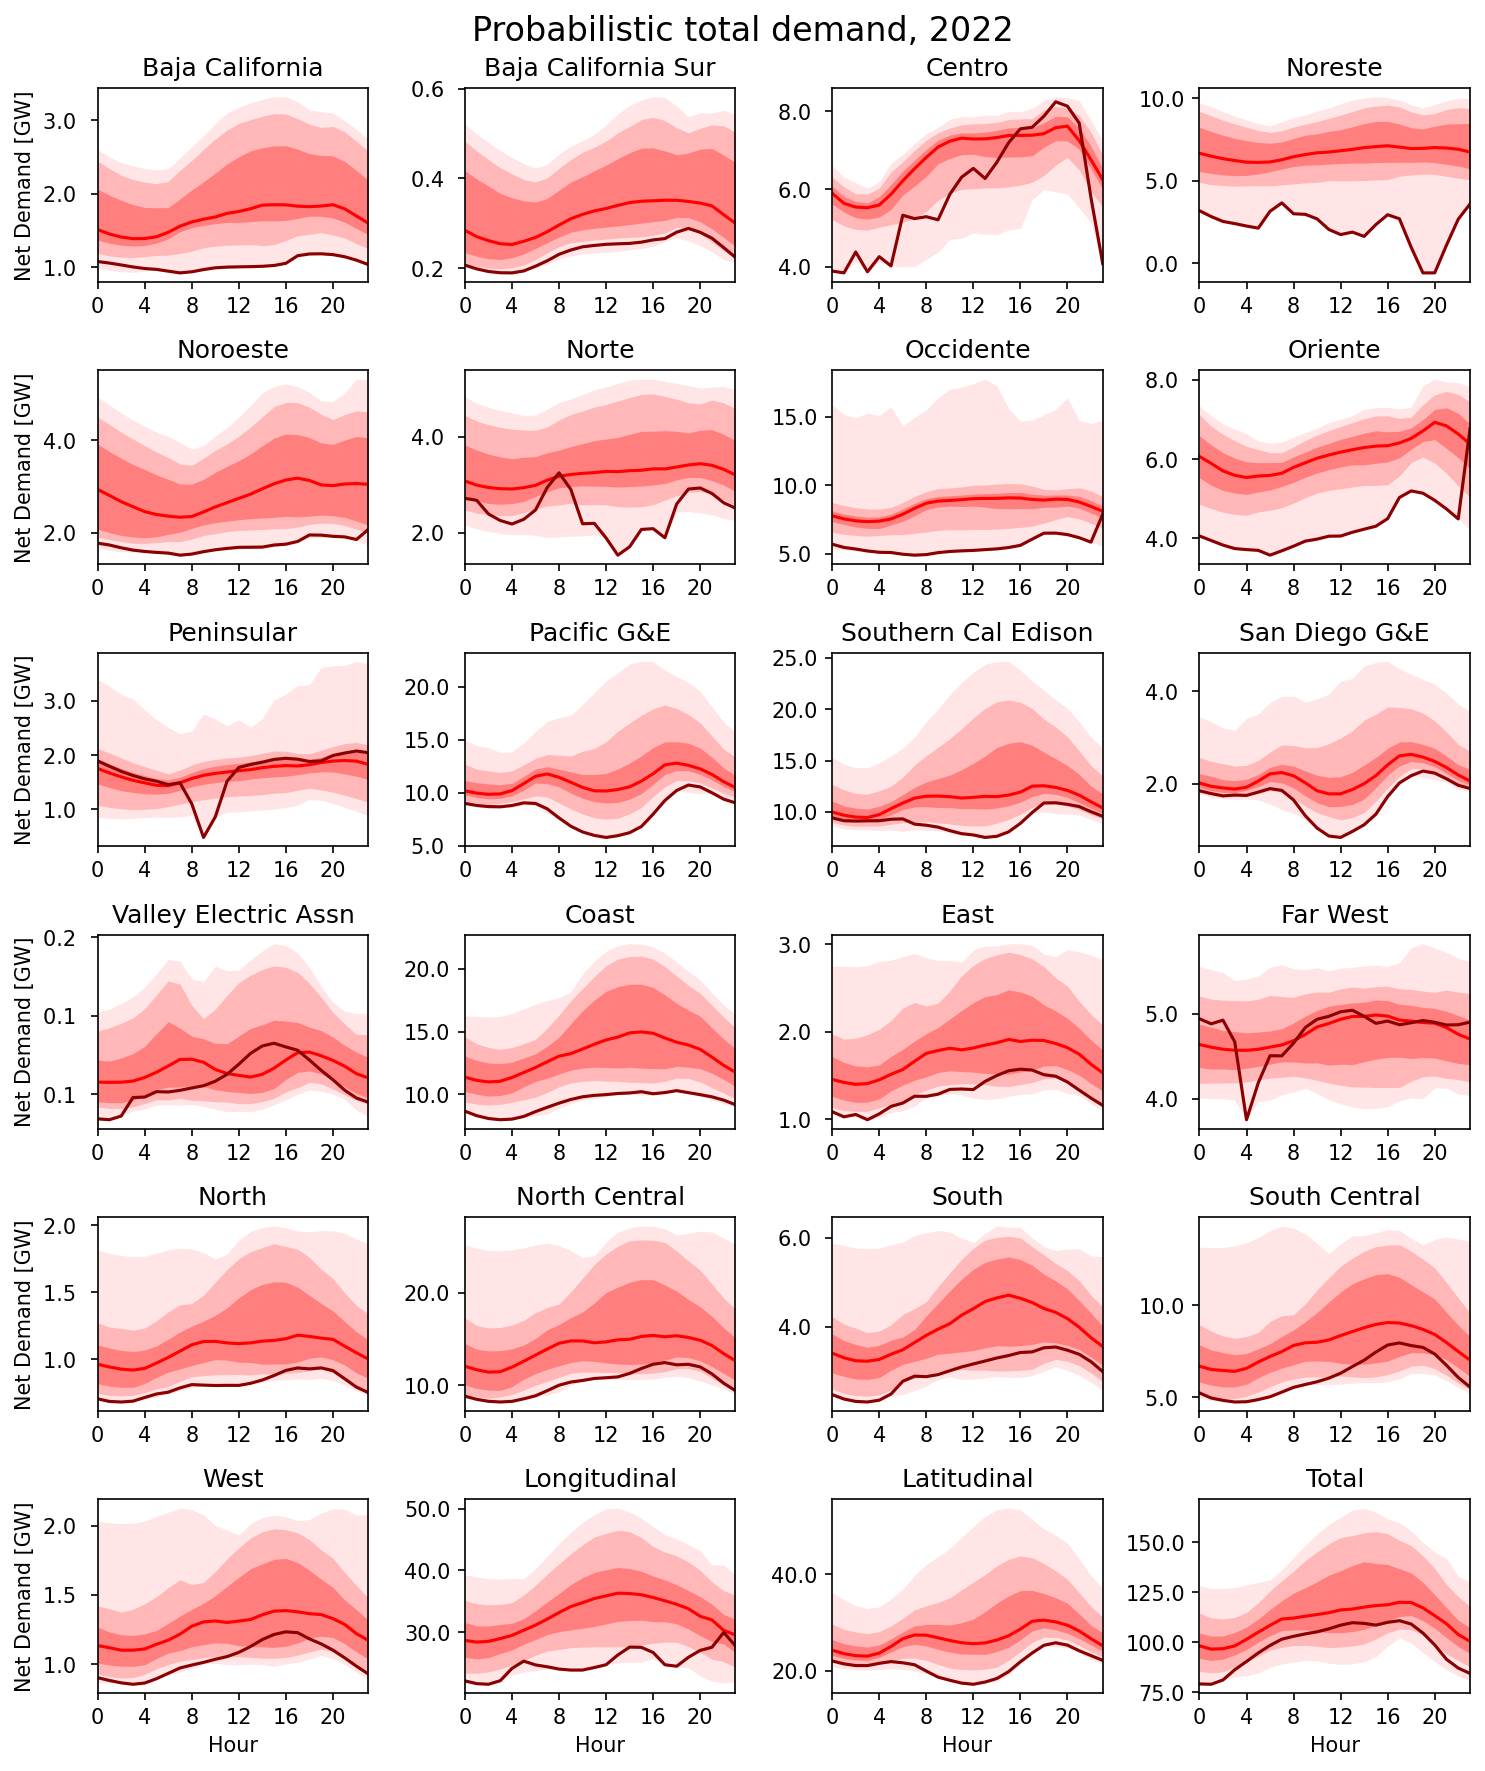

In [84]:
# Gráfica de demanda total

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

for i, c in enumerate( ds_d["REGION"].values ):
    reg = NAME_REGION_r(c)
    df = ds_d.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    if c in [22, 23, 24]: df = df[df.index.dayofyear.isin(range(2, 365))]

    # Procesamos datos
    a = df[ ["hour", "dayofyear", "Demand"]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = "Demand" ) / 1000
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    axes[i].fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #axes[i].fill_between(b.index, b[0.995], b[0.005],
    #  color = "red", alpha = 0.1, linewidth = 0)
    axes[i].fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    axes[i].fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    axes[i].plot(b.index, b[0.5], color = "red")
    axes[i].plot( a.index,
       a[a.min().sort_values().index[0]], color = "darkred" )

    # Formato de gráfica
    #axes[i].legend( ["Minimum-maximum envelope", "5-95% percentile",
    #    "25-75% percentile", "Median", "Day with minimum demand"] )
    axes[i].set_xlim(0, 23)
    #axes[i].set_ylim(0, 20000)
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes[i].yaxis.set_major_formatter(StrMethodFormatter("{x:<4.1f}"))
    if i%4 == 0: axes[i].set_ylabel("Net Demand [GW]")
    axes[i].set_title(reg)

# Formato de toda la gráfica
for i in [-4, -3, -2, -1]: axes[i].set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

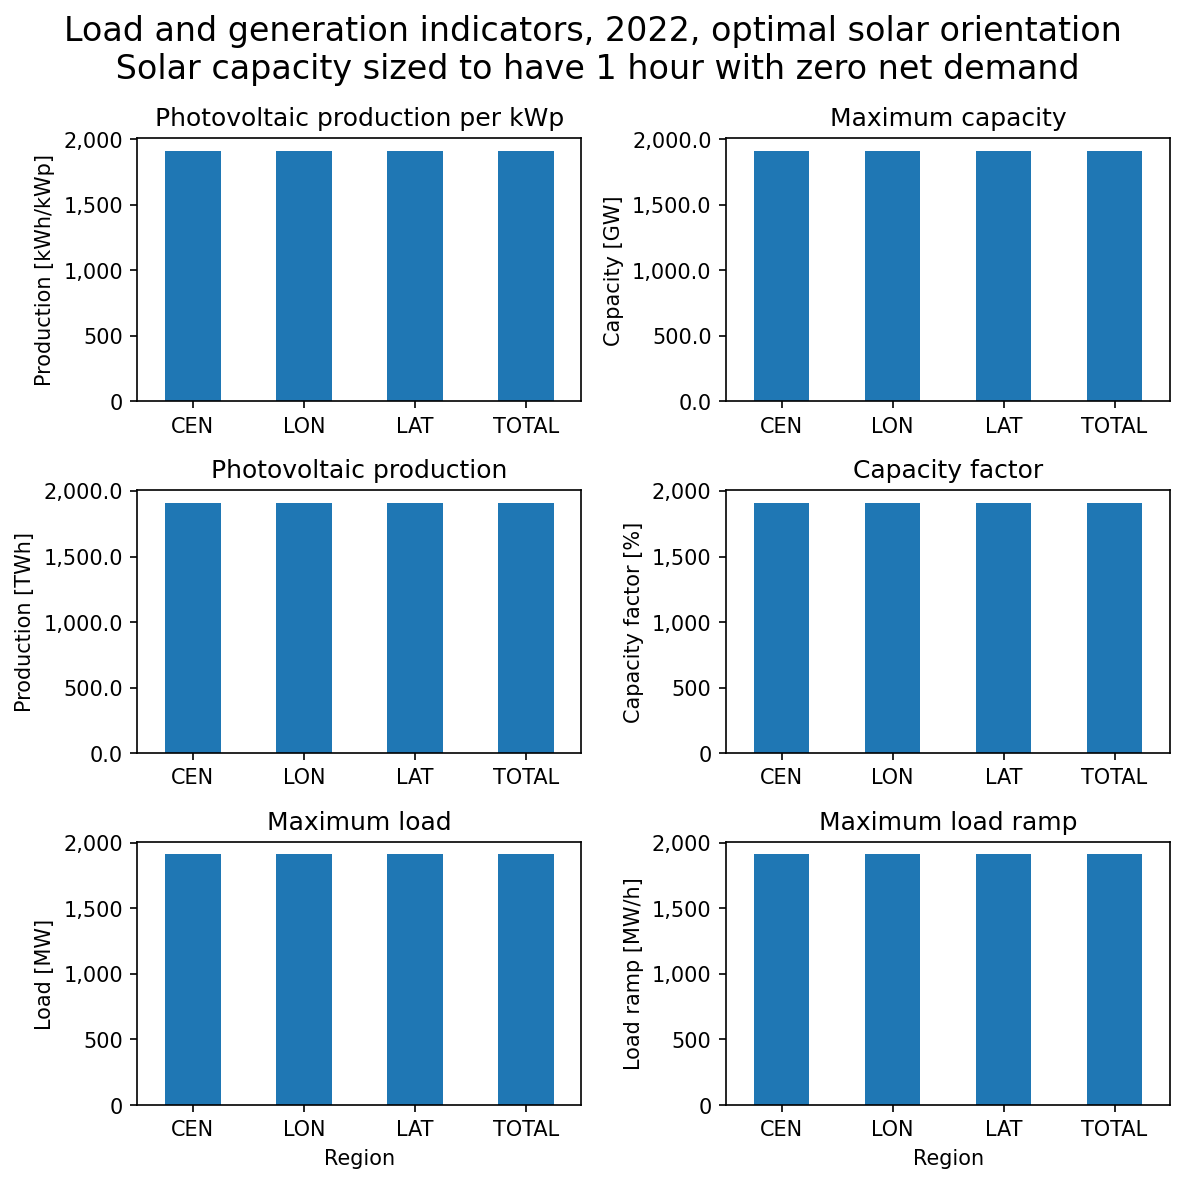

In [85]:
# Comparamos cada variable para las distintas regiones

# Escogemos la configuración ideal para cada región
conf_i = max_score.apply(lambda x: names_dn.index(x))

# Incializamos gráfica
fig, axes = plt.subplots(3, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Photovoltaic production per kWp
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[0], rot = 0, legend = False )
axes[0].set_title("Photovoltaic production per kWp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Production [kWh/kWp]")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[0].set_ylim(11, 12)

# Maximum capacity
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[1], rot = 0, legend = False )
axes[1].set_title("Maximum capacity")
axes[1].set_xlabel("")
axes[1].set_ylabel("Capacity [GW]")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
#axes[1].set_ylim(11, 12)

# Photovoltaic production
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[2], rot = 0, legend = False )
axes[2].set_title("Photovoltaic production")
axes[2].set_xlabel("")
axes[2].set_ylabel("Production [TWh]")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
#axes[2].set_ylim(7800, 8400)

# Capacity factor
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[3], rot = 0, legend = False )
axes[3].set_title("Capacity factor")
axes[3].set_xlabel("")
axes[3].set_ylabel("Capacity factor [%]")
axes[3].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[3].set_ylim(7800, 8400)

# Maximum load
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[4], rot = 0, legend = False )
axes[4].set_title("Maximum load")
axes[4].set_xlabel("Region")
axes[4].set_ylabel("Load [MW]")
axes[4].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[4].set_ylim(7800, 8400)

# Maximum load ramp
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[5], rot = 0, legend = False )
axes[5].set_title("Maximum load ramp")
axes[5].set_xlabel("Region")
axes[5].set_ylabel("Load ramp [MW/h]")
axes[5].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[5].set_ylim(2500, 3100)

# Formato de toda la gráfica
fig.suptitle("Load and generation indicators, 2022, optimal solar orientation"
    + "\n Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

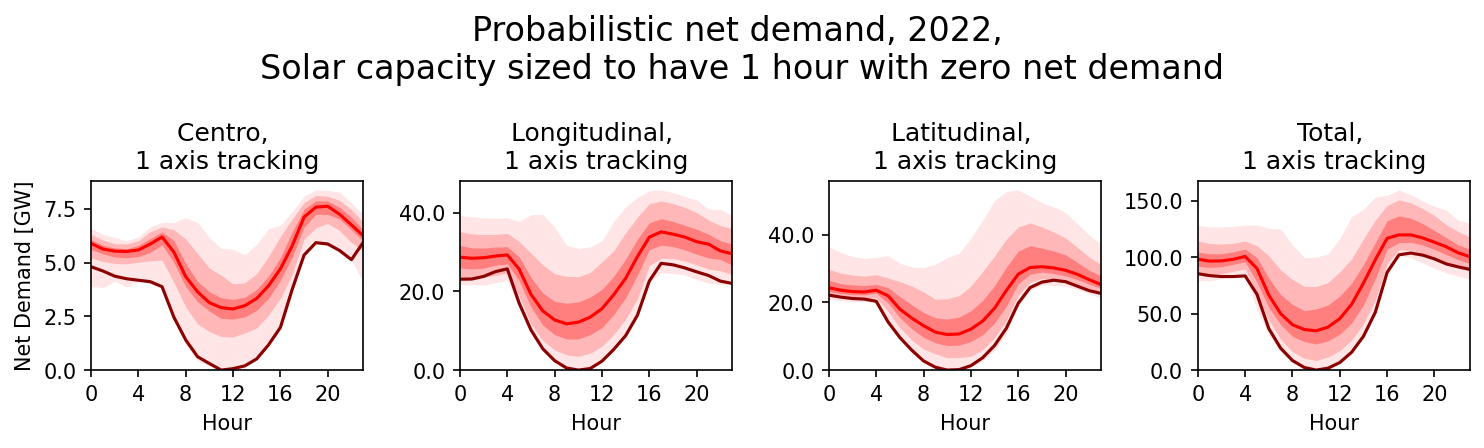

In [139]:
# Gráfica de demanda neta

# Incializamos gráfica
#fig, axes = plt.subplots(6, 4)
fig, axes = plt.subplots(1, 4)
axes = fig.axes
fig.set_facecolor("w")
#fig.set_size_inches(10, 12)
fig.set_size_inches(10, 3)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    c = ds_c["REGION"].values[i]
    a = ds_c.sel({"REGION": c}).drop_vars("REGION")[ [ "hour", "dayofyear",
        track_net_demand[24 + conf_i[c]] ] ].to_dataframe()
    a[track_net_demand[24 + conf_i[c]]] /= 1000
    a = a.reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[24 + conf_i[c]] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    ax.set_title(f"{NAME_REGION_r(c)}, \n{names_dn[conf_i[c]]}")
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%4 == 0: ax.set_ylabel("Net Demand [GW]")
    if len(axes) - i <= 4: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

# Resumen por región

In [86]:
# Escogemos los datos de una región
c = 24
reg = NAME_REGION_r(c)
df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()

# Resultados de producción fotovoltaica
pd.options.display.float_format = "{:,.0f} kWh/kWp".format

# Non-weighted
print(f"Photovoltaic production, non-weighted, {reg}")
a = df[prod_n_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Distributed
print()
print(f"Photovoltaic production, distributed, {reg}")
a = df[prod_n_dist_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Solar parks
print()
print(f"Photovoltaic production, solar parks, {reg}")
a = df[prod_n_centr_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Photovoltaic production
print()
print(f"Photovoltaic production, total, {reg}")
a = df[prod_n_total_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())


Photovoltaic production, non-weighted, Total
2_track_P_mp                  2,173 kWh/kWp
1_track_P_mp                  2,063 kWh/kWp
bifacial_south_P_mp           1,944 kWh/kWp
south_no_track_P_mp           1,764 kWh/kWp
east_no_track_P_mp            1,683 kWh/kWp
west_no_track_P_mp            1,616 kWh/kWp
bifacial_vertical_east_P_mp   1,358 kWh/kWp
bifacial_vertical_west_P_mp   1,315 kWh/kWp

Photovoltaic production, distributed, Total
south_no_track_P_mp           1,763 kWh/kWp
west_no_track_P_mp            1,763 kWh/kWp
east_no_track_P_mp            1,763 kWh/kWp
1_track_P_mp                  1,763 kWh/kWp
2_track_P_mp                  1,763 kWh/kWp
bifacial_vertical_west_P_mp   1,763 kWh/kWp
bifacial_vertical_east_P_mp   1,763 kWh/kWp
bifacial_south_P_mp           1,763 kWh/kWp

Photovoltaic production, solar parks, Total
2_track_P_mp                  2,173 kWh/kWp
1_track_P_mp                  2,063 kWh/kWp
bifacial_south_P_mp           1,944 kWh/kWp
south_no_track_P_mp          

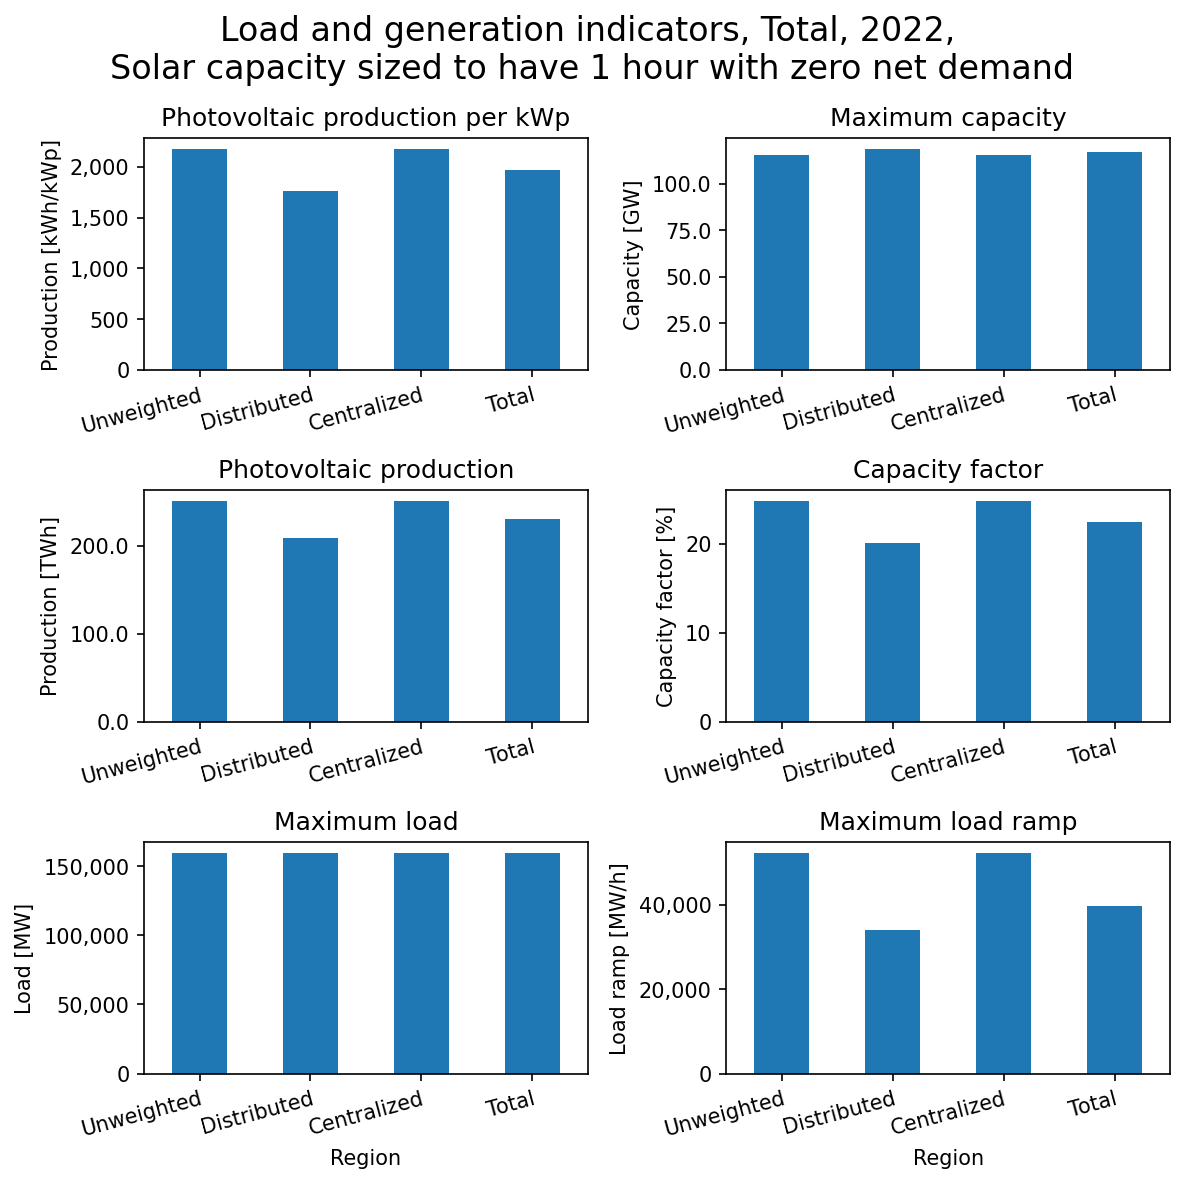

In [87]:
# Comparamos cada variable para los distintos tipos de producción solar

# Incializamos gráfica
fig, axes = plt.subplots(3, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Photovoltaic production per kWp
a = df[prod_n_sum_i[4::8]].iloc[0].plot.bar( ax = axes[0] )
axes[0].set_title("Photovoltaic production per kWp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Production [kWh/kWp]")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[0].set_ylim(11, 12)

# Maximum capacity
a = df[prod_n_cap[4::8]].iloc[0].plot.bar( ax = axes[1] )
axes[1].set_title("Maximum capacity")
axes[1].set_xlabel("")
axes[1].set_ylabel("Capacity [GW]")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
axes[1].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[1].set_ylim(11, 12)

# Photovoltaic production
a = df[ener[4::8]].iloc[0].plot.bar( ax = axes[2] )
axes[2].set_title("Photovoltaic production")
axes[2].set_xlabel("")
axes[2].set_ylabel("Production [TWh]")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
axes[2].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[2].set_ylim(7800, 8400)

# Capacity factor
a = df[cap_f[4::8]].iloc[0].plot.bar( ax = axes[3] )
axes[3].set_title("Capacity factor")
axes[3].set_xlabel("")
axes[3].set_ylabel("Capacity factor [%]")
axes[3].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[3].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[3].set_ylim(7800, 8400)

# Maximum load
a = df[track_net_demand_max[4::8]].iloc[0].plot.bar( ax = axes[4] )
axes[4].set_title("Maximum load")
axes[4].set_xlabel("Production weighting")
axes[4].set_ylabel("Load [MW]")
axes[4].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[4].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[4].set_ylim(7800, 8400)

# "Maximum load ramp"
a = df[track_net_demand_dt_max[4::8]].iloc[0].plot.bar( ax = axes[5] )
axes[5].set_title("Maximum load ramp")
axes[5].set_xlabel("Region")
axes[5].set_ylabel("Load ramp [MW/h]")
axes[5].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[5].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[5].set_ylim(2500, 3100)

# Formato de toda la gráfica
fig.suptitle(f"Load and generation indicators, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:38: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscor

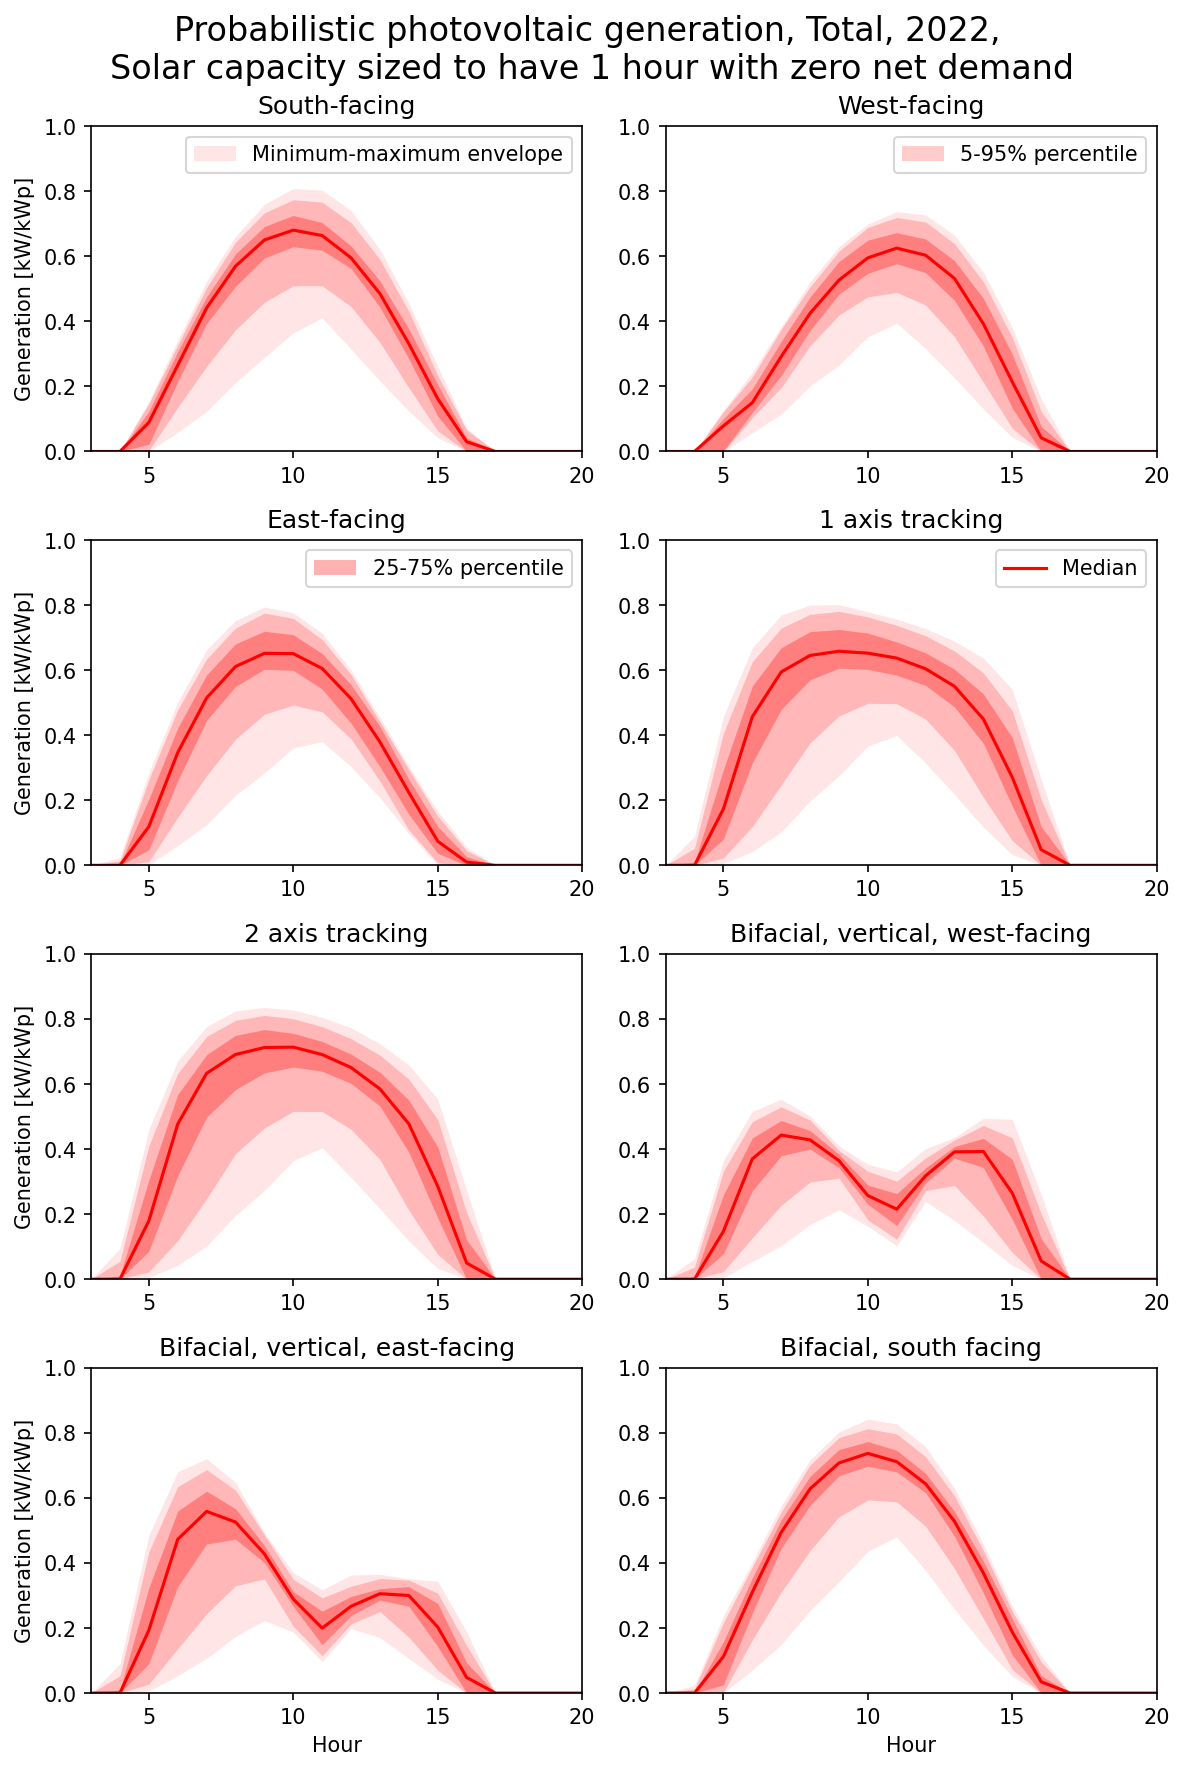

In [88]:
# Gráfica de producción fotovoltaica

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos los datos
    a = df[ ["hour", "dayofyear", prod_n[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(3, 20)
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%2 == 0: ax.set_ylabel("Generation [kW/kWp]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic photovoltaic generation, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

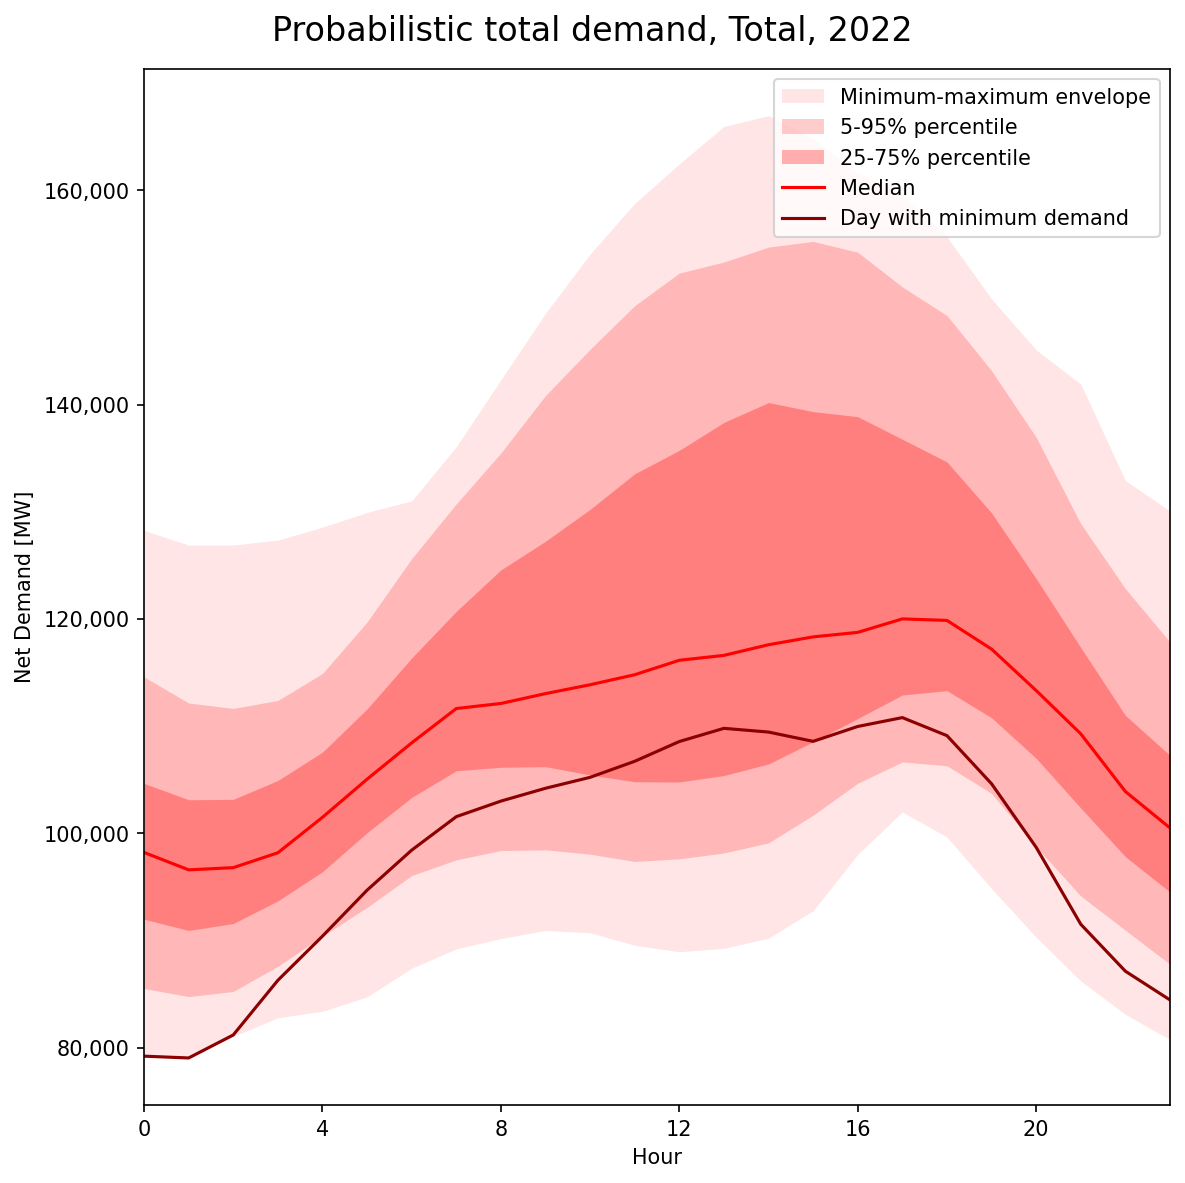

In [100]:
# Gráfica de demanda total

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Procesamos datos
a = df[ ["hour", "dayofyear", "Demand"]
    ].reset_index(drop = True).pivot( index = "hour",
    columns = "dayofyear", values = "Demand" )
if c in [22, 23, 24]: a = a.drop(columns = [1, 365])
b = a.quantile([0, 0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995, 1], axis = 1).T

# Graficamos
ax.fill_between(b.index, b[1], b[0],
    color = "red", alpha = 0.1, linewidth = 0)
#ax.fill_between(b.index, b[0.995], b[0.005],
#    color = "red", alpha = 0.1, linewidth = 0)
ax.fill_between(b.index, b[0.95], b[0.05],
    color = "red", alpha = 0.2, linewidth = 0)
ax.fill_between(b.index, b[0.75], b[0.25],
    color = "red", alpha = 0.3, linewidth = 0)
ax.plot(b.index, b[0.5], color = "red")
ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

# Formato de gráfica
ax.legend( ["Minimum-maximum envelope", "5-95% percentile",
    "25-75% percentile", "Median", "Day with minimum demand"] )
ax.set_xlim(0, 23)
#ax.set_ylim(3500, 8500)
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Net Demand [MW]")
ax.set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, {reg}, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

In [90]:
# Resultados para cada configuración
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
     track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
indicators = [ "Photovoltaic production per kWp", "Maximum capacity",
    "Photovoltaic production", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
format = [ "{:,.0f} kWh/kWp".format, "{:.1f} GW".format,
           "{:,.0f} TWh".format, "{:.1f} %".format,
           "{:,.0f} MW".format, "{:,.0f} MW".format]

for i in range(len(results)):
    print(indicators[i])
    pd.options.display.float_format = format[i]
    a = df[results[i]].iloc[i]
    a.index = names_dn
    print( a.sort_values(ascending = False).to_string() )
    print()

Photovoltaic production per kWp
2 axis tracking                   1,966 kWh/kWp
1 axis tracking                   1,911 kWh/kWp
Bifacial, south facing            1,853 kWh/kWp
South-facing                      1,763 kWh/kWp
East-facing                       1,722 kWh/kWp
West-facing                       1,688 kWh/kWp
Bifacial, vertical, east-facing   1,560 kWh/kWp
Bifacial, vertical, west-facing   1,539 kWh/kWp

Maximum capacity
Bifacial, vertical, west-facing   161.6 GW
Bifacial, vertical, east-facing   145.1 GW
West-facing                       125.1 GW
East-facing                       121.1 GW
1 axis tracking                   121.0 GW
South-facing                      118.4 GW
2 axis tracking                   117.0 GW
Bifacial, south facing            115.5 GW

Photovoltaic production
Bifacial, vertical, west-facing   249 TWh
1 axis tracking                   231 TWh
2 axis tracking                   230 TWh
Bifacial, vertical, east-facing   226 TWh
Bifacial, south facing       

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:36: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:39: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscor

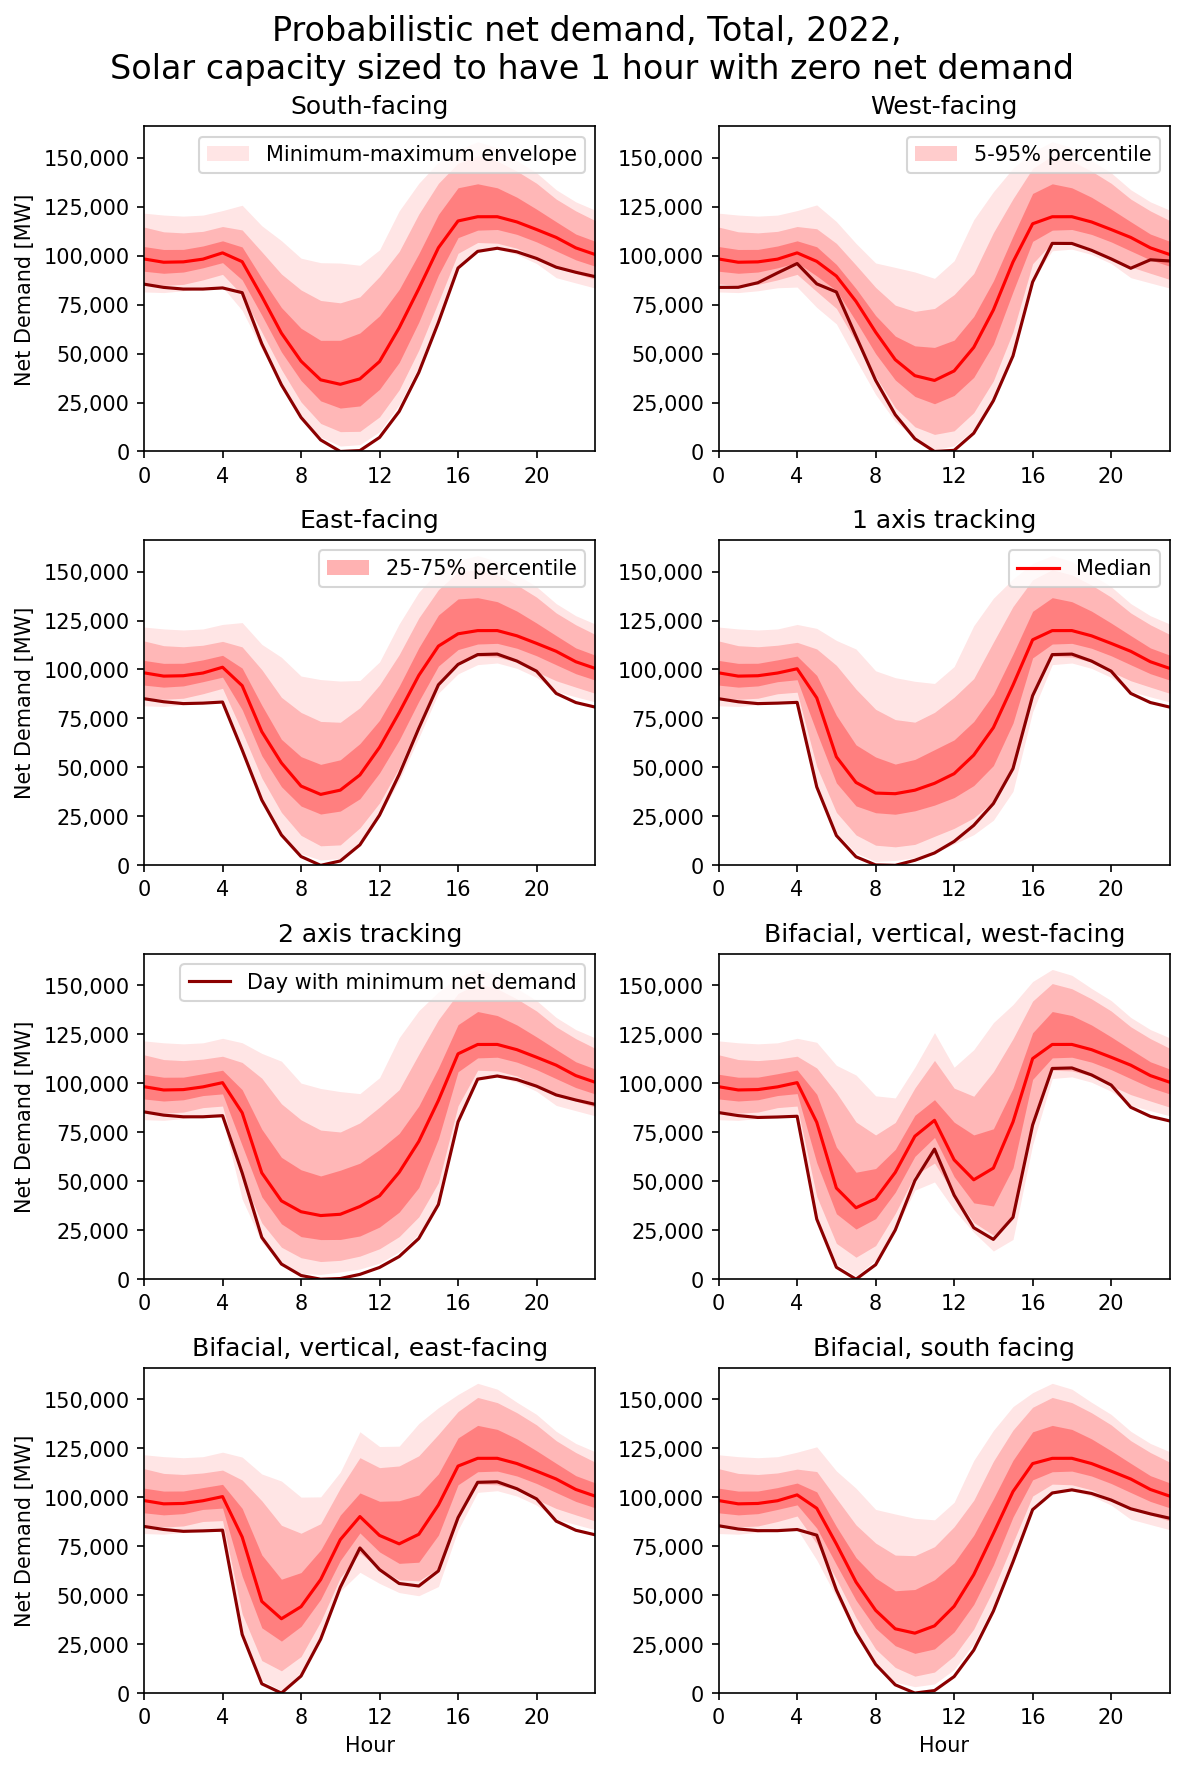

In [91]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    a = df[ ["hour", "dayofyear", track_net_demand[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    #ax.fill_between(b.index, b[1], b[0],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.995], b[0.005],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 4:
        ax.legend( ["_", "_", "_", "_", "Day with minimum net demand"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [MW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

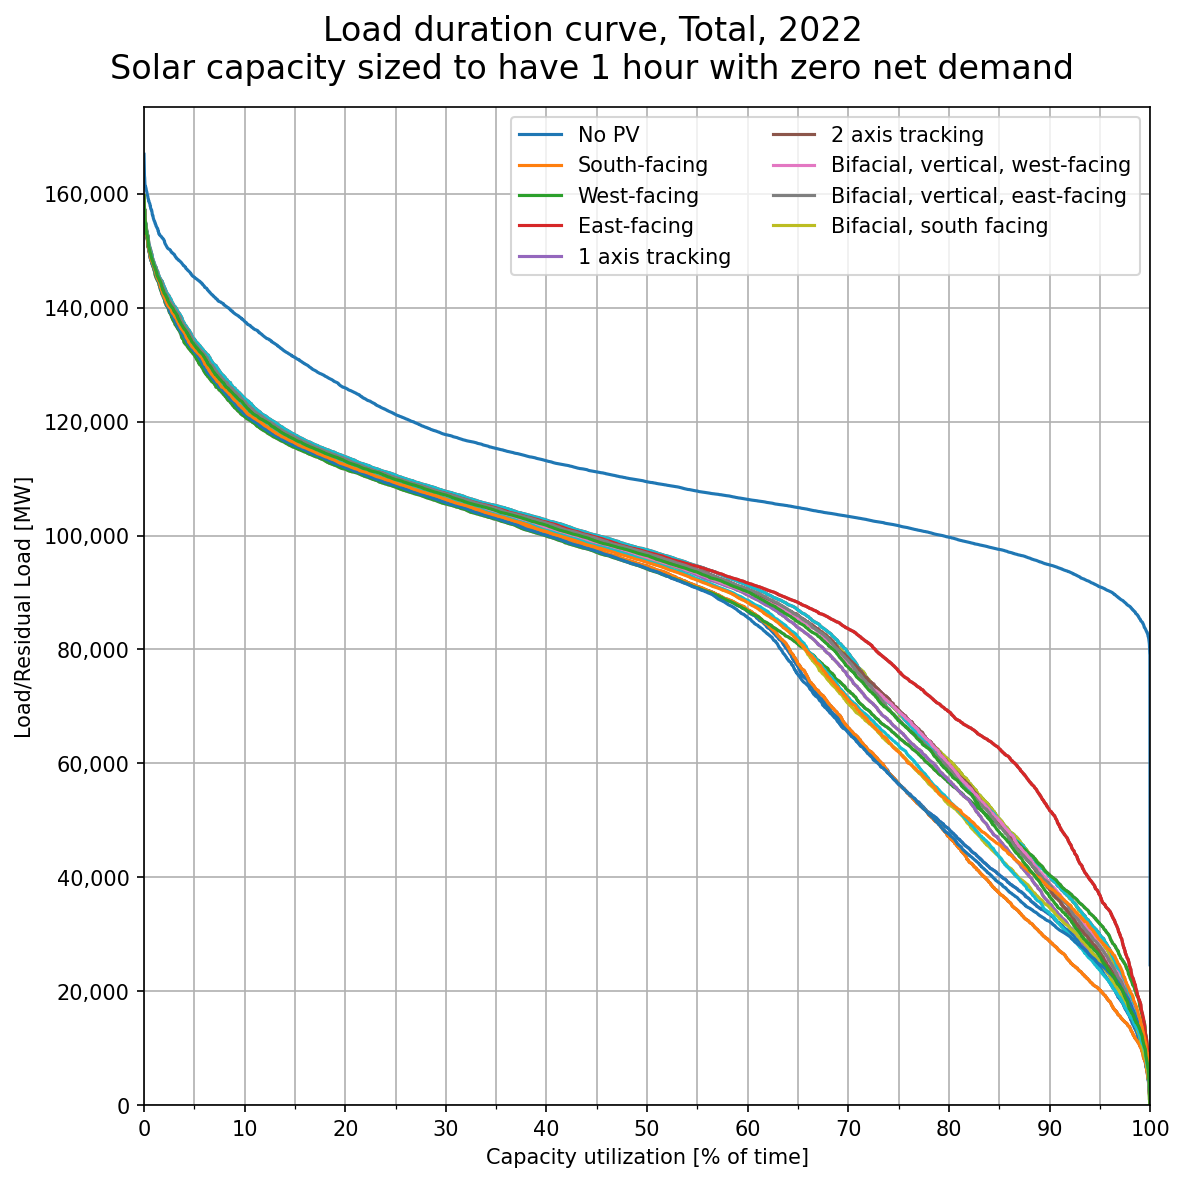

In [92]:
# Load duration curve

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn, ncol = 2 )
ax.set_xlim(0, 100)
#ax.set_ylim(0, 8500)
ax.set_ylim(0)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
#ax.yaxis.set_minor_locator(plt.MultipleLocator(500))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Load/Residual Load [MW]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3223343924.py:26: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3223343924.py:40: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )


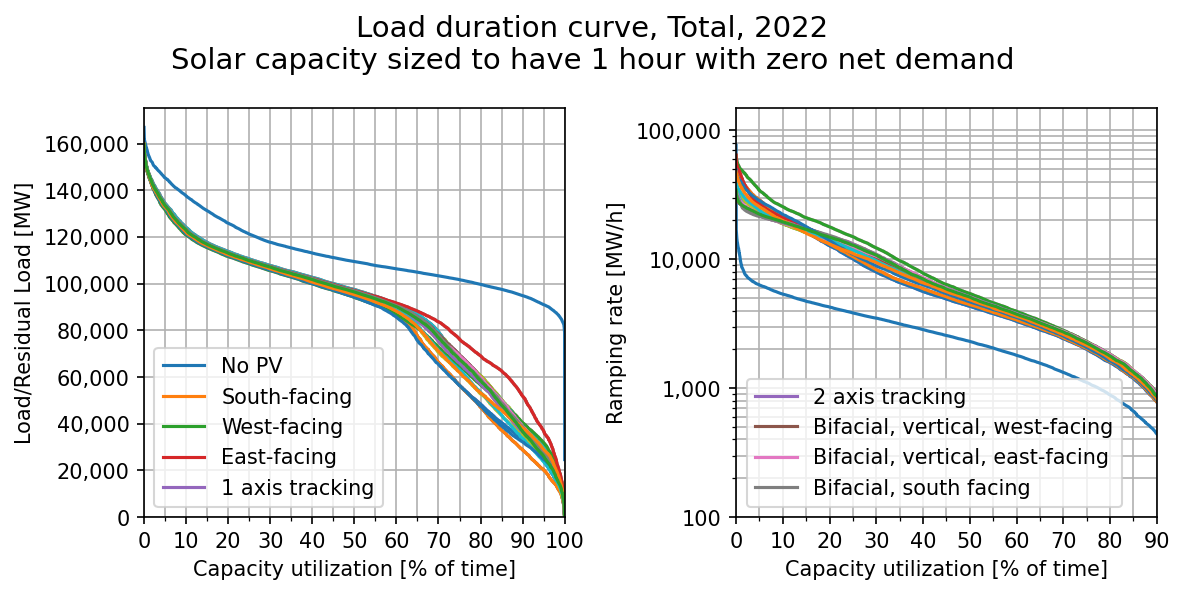

In [93]:
# Load duration curve + ramp duration curve

# Incializamos gráfica
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    axes[0].plot(a.index, a[v])

# Iteramos para cada caso
for v in ["Demand_dt"] + track_net_demand_dt:
    a = np.abs(df[[v]]).sort_values( v,
        ascending = False ).reset_index(drop = True)
    a = a.where(a>0, 0)
    a.index = a.index / a.index.max() * 100
    axes[1].plot(a.index, a[v])

# Formato de gráfica
axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
axes[0].set_xlim(0, 100)
#axes[0].set_ylim(0, 8500)
axes[0].set_ylim(0)
axes[0].grid("both", "both")
axes[0].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(5))
#axes[0].yaxis.set_major_locator(plt.MultipleLocator(1000))
#axes[0].yaxis.set_minor_locator(plt.MultipleLocator(500))
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].set_ylabel("Load/Residual Load [MW]")
axes[0].set_xlabel("Capacity utilization [% of time]")

# Formato de gráfica
axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )
axes[1].set_yscale("log")
axes[1].set_xlim(0, 90)
axes[1].set_ylim(100)
axes[1].grid("both", "both")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(5))
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[1].set_ylabel("Ramping rate [MW/h]")
axes[1].set_xlabel("Capacity utilization [% of time]")

fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 14)
fig.tight_layout()
plt.show()